In [2]:
import os
import pandas as pd
import pickle
from library.scoreCalculatorLibrary import calculate_score

In [3]:
# converts hour:minute:seconds to seconds
def time_as_int(timestr):
    hh, mm, ss = timestr.split(":")
    time_int = (int(hh)*3600)+(int(mm)*60)+int(ss)
    return time_int

In [96]:
#name = "prantika_bus_stand"
#name = "junction_mall"
#name = "54ft_road"
#name = "dvc_more"
name = "station"

In [97]:
parent_dir = r"../data/54ft/"
results_csv_name = f"Predictions_merged_54ft_{name}_zone.csv"
reports_dir = f"../reports/54ft/{name}"
plots_dir_name = r"score_plots&correlations"
instance_score_dir = r"instance_wise_scores"
#scores_pickle = f"scores_pickle_{name}"

column = 'instance_date'

In [98]:
os.makedirs(reports_dir, exist_ok=True)
os.makedirs(os.path.join(reports_dir, plots_dir_name), exist_ok=True)
os.makedirs(os.path.join(reports_dir, instance_score_dir), exist_ok=True)

In [99]:
result_df = pd.read_csv(os.path.join(parent_dir, results_csv_name))
date_group = result_df.groupby(column)

In [100]:
keys = list(date_group.groups.keys())
all_scores = {}
instance_scores = {}
instances_count = {}
for key in keys:
    df = date_group.get_group(key).copy()
    df["instance_start_time"] = df["instance_start_time"].apply(lambda x: time_as_int(x))
    df["instance_end_time"] = df["instance_end_time"].apply(lambda x: time_as_int(x))
    overall_score, list_scores, no_of_instances = calculate_score(df)
    all_scores[key] = overall_score
    instance_scores[key] = list_scores
    instances_count[key] = no_of_instances

In [101]:
all_scores

{'09/14/2019': -0.0855406321048695,
 '09/15/2019': -0.654895863390146,
 '09/16/2019': -0.1994915035134247,
 '09/17/2019': -2.120828490524005,
 '09/20/2019': 0.5336845195343396,
 '09/21/2019': -0.16534273956131676,
 '09/23/2019': -0.6267532729129839}

In [102]:
instances_count

{'09/14/2019': 4,
 '09/15/2019': 6,
 '09/16/2019': 6,
 '09/17/2019': 12,
 '09/20/2019': 5,
 '09/21/2019': 12,
 '09/23/2019': 13}

## creating instance wise score df

In [103]:
def generate_time_list(df, time_column):
    times = []
    
    for index, row in df.iterrows():
        condition = row["Prediction Is_Adhoc"] == "Adhoc" or row["Prediction Is_Bus_stop"] == "Bus_stop" \
        or row["Prediction Is_Signal"] == "Signal" or row["Prediction Is_Congestion"] == "Congestion"
        if condition:
            times.append(row[time_column])
        else:
            pass
    
    return times

In [104]:
def generate_instance_score_df(start_times, end_times, scores):
    df = pd.DataFrame(columns=['start_time', 'end_time', 'score'])
    df['start_time'] = start_times
    df['end_time'] = end_times
    df['score'] = scores
    return df

In [105]:
def format_date(mmddyyyy):
    mmddyyyy = mmddyyyy.split("/")
    ddmmyyyy = f"{mmddyyyy[1]}_{mmddyyyy[0]}_{mmddyyyy[2]}"
    return ddmmyyyy

In [106]:
instance_score_dfs = {}
instance_start_times = {}
instance_end_times = {}
for key in keys:
    df = date_group.get_group(key).copy()
    start_times = generate_time_list(df, 'instance_start_time')
    end_times = generate_time_list(df, 'instance_end_time')
    instance_start_times[key] = start_times
    instance_end_times[key] = end_times
    instance_score_dfs[key] = generate_instance_score_df(start_times, end_times, instance_scores[key])

In [107]:
for key in instance_score_dfs:
    csv_name = format_date(key)
    path = os.path.join(reports_dir, instance_score_dir, f"{csv_name}.csv")
    df = instance_score_dfs[key]
    print(f"{key}: {len(df)}")
    df.to_csv(path, index=False)

09/14/2019: 4
09/15/2019: 6
09/16/2019: 6
09/17/2019: 12
09/20/2019: 5
09/21/2019: 12
09/23/2019: 13


## Plots

In [108]:
import matplotlib.pyplot as plt

### Boxplot

In [109]:
data = [instance_scores.get(key) for key in instance_scores.keys()]

#### Saving Scores Pickle

In [110]:
with open(os.path.join(reports_dir, scores_pickle), "wb") as outfile:
    pickle.dump(data, outfile)

#### Plotting

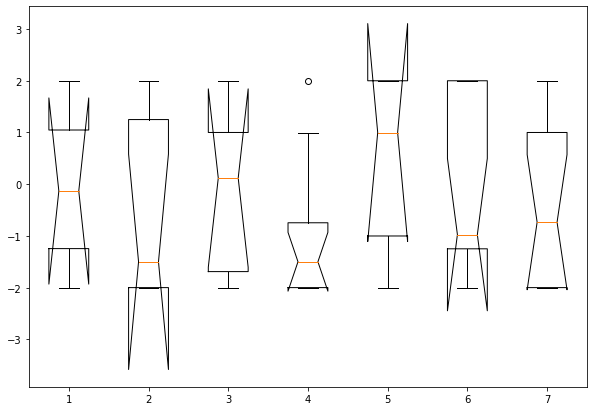

In [111]:
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot()
ax.boxplot(data, notch=True)
fig.savefig(os.path.join(reports_dir, plots_dir_name, "boxplot.png"))
plt.show()

###  View plots

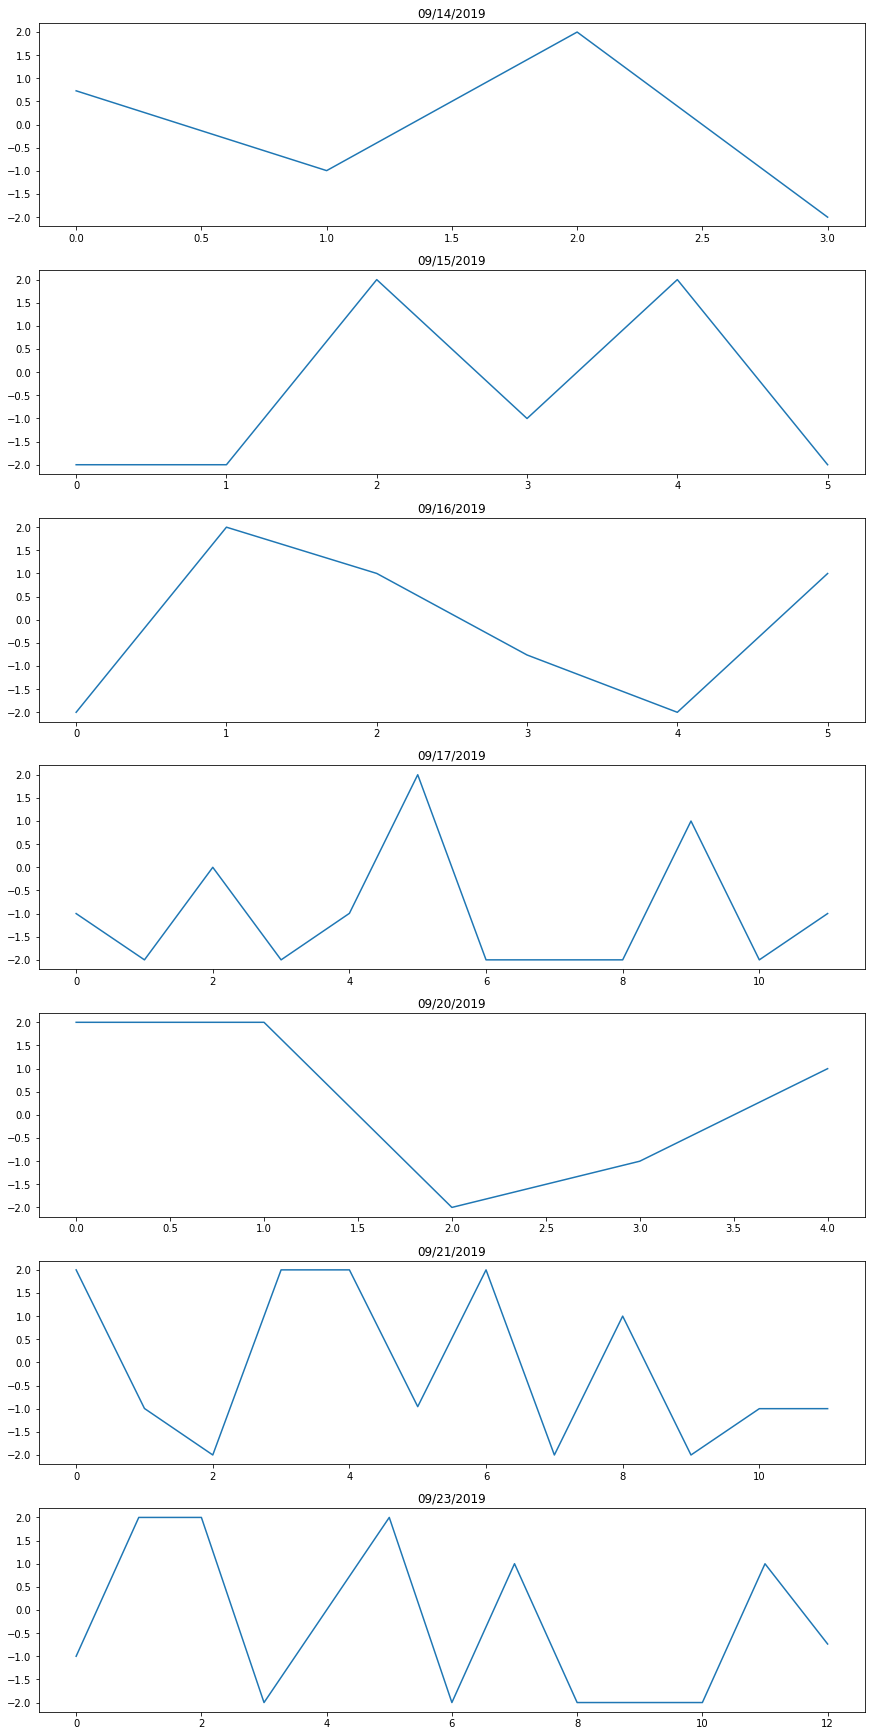

In [112]:
fig, axes = plt.subplots(len(instance_scores), 1, squeeze=False, figsize=(12, 24), constrained_layout=True)
keys = list(instance_scores.keys())
key_index = 0
for key, ax in zip(instance_scores, axes.flat):
    ax.plot(instance_scores.get(key))
    ax.set_title(key)

### Save Plots

In [113]:
for key in instance_scores:
    fig = plt.figure(figsize=(14, 6))
    ax = plt.subplot()
    ax.plot(instance_scores.get(key))
    ax.set_title(key)
    outname = "-".join(key.split("/"))
    fig.savefig(os.path.join(reports_dir, plots_dir_name, f"{outname}.png"))
    plt.close(fig)

## Correlation

In [114]:
from library.correlationAndTtestLib import *

In [115]:
pairs_with_scores = form_pairs_with_scores(instance_scores)
print("Total pairs formed: %d" %len(pairs_with_scores))

Total pairs formed: 21


### Kendalltau

In [116]:
kendalltau_correlations, pair_instance_count = kendalltau_corr(pairs_with_scores)
kendalltau_correlations

{('09/14/2019', '09/15/2019'): (0.18257418583505539, 0.7179816667337768),
 ('09/14/2019', '09/16/2019'): (0.0, 1.25),
 ('09/14/2019', '09/17/2019'): (0.9128709291752769, 0.07095149242730567),
 ('09/14/2019', '09/20/2019'): (-0.18257418583505539, 0.7179816667337768),
 ('09/14/2019', '09/21/2019'): (-0.5477225575051662, 0.2785986718379626),
 ('09/14/2019', '09/23/2019'): (0.5477225575051662, 0.2785986718379626),
 ('09/15/2019', '09/16/2019'): (-0.16116459280507606, 0.6762143430517156),
 ('09/15/2019', '09/17/2019'): (0.16116459280507606, 0.6762143430517156),
 ('09/15/2019', '09/20/2019'): (-0.7071067811865475, 0.10712339925384028),
 ('09/15/2019', '09/21/2019'): (0.0, 1.0),
 ('09/15/2019', '09/23/2019'): (-0.08703882797784893, 0.826580701439357),
 ('09/16/2019', '09/17/2019'): (-0.07142857142857144, 0.8456867367859529),
 ('09/16/2019', '09/20/2019'): (-0.2222222222222222, 0.6027418291290805),
 ('09/16/2019', '09/21/2019'): (-0.7715167498104596, 0.040664437290414975),
 ('09/16/2019', '09/

In [117]:
pair_instance_count

{('09/14/2019', '09/15/2019'): 4,
 ('09/14/2019', '09/16/2019'): 4,
 ('09/14/2019', '09/17/2019'): 4,
 ('09/14/2019', '09/20/2019'): 4,
 ('09/14/2019', '09/21/2019'): 4,
 ('09/14/2019', '09/23/2019'): 4,
 ('09/15/2019', '09/16/2019'): 6,
 ('09/15/2019', '09/17/2019'): 6,
 ('09/15/2019', '09/20/2019'): 5,
 ('09/15/2019', '09/21/2019'): 6,
 ('09/15/2019', '09/23/2019'): 6,
 ('09/16/2019', '09/17/2019'): 6,
 ('09/16/2019', '09/20/2019'): 5,
 ('09/16/2019', '09/21/2019'): 6,
 ('09/16/2019', '09/23/2019'): 6,
 ('09/17/2019', '09/20/2019'): 5,
 ('09/17/2019', '09/21/2019'): 12,
 ('09/17/2019', '09/23/2019'): 12,
 ('09/20/2019', '09/21/2019'): 5,
 ('09/20/2019', '09/23/2019'): 5,
 ('09/21/2019', '09/23/2019'): 12}

### Welch's T-Test

In [118]:
welch = welch_t(pairs_with_scores)
welch

{('09/14/2019', '09/15/2019'): (0.36159357876119336, 0.7282025941914076),
 ('09/14/2019', '09/16/2019'): (0.0539924916493602, 0.9585988058478766),
 ('09/14/2019', '09/17/2019'): (0.961102693998984, 0.3883285837833583),
 ('09/14/2019', '09/20/2019'): (-0.3861727867358648, 0.7114599250152556),
 ('09/14/2019', '09/21/2019'): (0.012784939100865972, 0.9902896694129362),
 ('09/14/2019', '09/23/2019'): (0.21999772780139887, 0.8348972542568526),
 ('09/15/2019', '09/16/2019'): (-0.3507076856150179, 0.7332392608605836),
 ('09/15/2019', '09/17/2019'): (0.5577530771350004, 0.5934372136395263),
 ('09/15/2019', '09/20/2019'): (-0.7859241542686606, 0.45238753799775344),
 ('09/15/2019', '09/21/2019'): (-0.44428268188727227, 0.6673735440232592),
 ('09/15/2019', '09/23/2019'): (-0.22802615721897648, 0.8249766952129755),
 ('09/16/2019', '09/17/2019'): (1.0957173697645317, 0.3041160255555349),
 ('09/16/2019', '09/20/2019'): (-0.49232873053994686, 0.6351011416379864),
 ('09/16/2019', '09/21/2019'): (-0.056